In [1]:
import warnings
warnings.filterwarnings('ignore')

In [61]:
import re 
import us
import pandas as pd
import nltk
import lightgbm
import yellowbrick
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn import feature_extraction
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


stopwords = set(stopwords.words('english'))
train = pd.read_csv('./data/train_cleaned.csv')
test = pd.read_csv('./data/test_cleaned.csv')

# Run once and save

In [38]:
from spellchecker import SpellChecker
spell = SpellChecker()
def correct_spelling(text): 
    words = text.split()
    mispelled_words = spell.unknown(words)
    master = [spell.correction(word) if word in mispelled_words else word for word in words]
    return " ".join(master)

In [42]:
# # %%time 
# train['text'] = train['text'].apply(correct_spelling)
# test['text'] = test['text'].apply(correct_spelling)
# train.to_csv('./data/train_cleaned.csv')
# test.to_csv('./data/test_cleaned.csv')

# Feat eng

In [43]:
def get_len(x): 
    return len(x.split(' '))
def get_chars(x): 
    return len(x)
def remove_URL(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def get_states(x): 
    states = pd.Series(us.states.STATES)
    states = pd.DataFrame(us.states.mapping('abbr','name'), index=[0]).T.reset_index().rename(columns={0:'State'})
    states['index'] = states['index'].str.lower()
    states['State'] = states['State'].str.lower()
    states.set_index('index',inplace=True)
    state = states.to_dict()['State']
    abbrev = states.index.tolist()
    names = states['State'].tolist()
    
    words = x.split(' ')
    words = [word for word in words if word not in ['in','co', 'as','or','oh','id','hi','me', 'ok']]
    return [word for word in words if word in names ] # or word in abbrev

# Get State Features

In [44]:
train['cleaned'] = train['text'].str.replace('\W', ' ').str.lower()
test['cleaned'] = test['text'].str.replace('\W', ' ').str.lower()
train['states'] = train['cleaned'].apply(get_states)
test['states'] = test['cleaned'].apply(get_states)
train['states']=train['states'].fillna('none')
test['states']=test['states'].fillna('none')

le=LabelEncoder()
train['states'] = train['states'].apply(lambda x: ' '.join(x))
test['states'] = test['states'].apply(lambda x: ' '.join(x))
train['states'] = le.fit_transform(train['states'])
test['states'] = le.fit_transform(test['states'])

# Get Len Feats

In [45]:
train['len'] = train['text'].apply(get_len)
train['char_len'] = train['text'].apply(get_chars)
test['len'] = test['text'].apply(get_len)
test['char_len'] = test['text'].apply(get_chars)

# Clean Text

In [54]:
%%time 
train['text'] = train['text'].apply(remove_URL)
train['text'] = train['text'].apply(remove_emoji)

CPU times: total: 31.2 ms
Wall time: 31 ms


# Steps
1. TFIDF
2. Normalization /  PCA
3. Cluster
4. OHE
5. Predict

In [55]:
from sklearn.base import TransformerMixin
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [56]:
P = make_pipeline(
                      TfidfVectorizer(
                                stop_words=stopwords, 
                                ngram_range=(1,1),
                                lowercase=True,
                                max_features=1000),
                      DenseTransformer(),
                      OneHotEncoder(handle_unknown='ignore'),
                      DenseTransformer(),
                      # StandardScaler(),
                      PCA(n_components=1000,),
                  )
X=P.fit_transform(train['text'])

In [57]:
X = pd.DataFrame(X)
X['sates'] = train['states']
X['len'] = train['len']
X['char_len'] =train['char_len']

# Split

In [58]:
X_train,X_test,y_train,y_test = train_test_split(
                                        X, # df 
                                        train['target'],
                                        stratify=train['target'], 
                                        random_state=0, 
                                        test_size=.2,
                                        )
model_feats={'num_leaves':30,
                'max_depth':-1,
                'n_estimators':100,
                'learning_rate':.14}

In [59]:
def metrics(m): 
    # AUC
    vis = yellowbrick.ROCAUC(m, classes=[0,1])
    vis.fit(X_train,y_train)
    vis.score(X_test,y_test)
    vis.show()

    # F1 Score
    scores = cross_val_score(m, X_train, y_train, cv=3, scoring='f1')
    print(scores.mean())

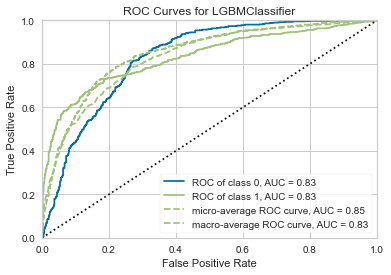

0.7115399006040996


In [60]:
m = lightgbm.LGBMClassifier(
        **model_feats
)
m.fit(X_train, y_train)
metrics(m)

In [ ]:
0.7115399006040996

0.7020873952604543

# Write Out

In [62]:
m = lightgbm.LGBMClassifier(
        **model_feats
    )
m.fit(X, train['target'])

LGBMClassifier(learning_rate=0.14, num_leaves=30)

In [63]:
X_val = pd.DataFrame(P.transform(test['text']))
X_val['len'] = test['len']
X_val['char_len'] = test['char_len']

C:\Users\crysi\anaconda3\envs\ds\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\crysi\anaconda3\envs\ds\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [64]:
preds = m.predict(X_val)
test['target'] = preds
# test.set_index('id')['target'].to_csv('tt.csv')

In [65]:
best = pd.read_csv('best.csv')

In [66]:
best['pred'] = preds
(best['target'] == best['pred']).value_counts()

True     2830
False     433
dtype: int64